<a href="https://colab.research.google.com/github/dkgithub/wiehl24/blob/main/skorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working with PyTorch can become involved. There are many tool that try to avoid writimg out all the litlle details.
Most commonly used is lighning. Here, we use skorch. It provides a Keras like interface that interacts smoothly with sklearn.

In [1]:
#!rm -rf helpers # if an enforced reinstall is necessary
![ ! -d helpers ] && git clone --recursive https://github.com/dkgithub/erum_ml_school_helpers helpers
!pip install wget

In [2]:
!pip install wget torchinfo skorch

In [3]:
# load the helpers package and other software
import helpers as hlp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torchinfo

In [4]:
#check for accelerators
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('torch',torch.__version__)
print('device type is',device)
if device == 'cuda' :print(torch.cuda.get_device_name())
from os import environ
if "COLAB_TPU_ADDR" in environ and environ["COLAB_TPU_ADDR"]:
  print("A TPU is connected.")


torch 2.1.0+cu121
device type is cuda


In [5]:
# first, we define a preprocessing function that (e.g.) takes the
# constiuents and returns another representation of them

#def preprocess_constituents(constituents):
#    return constituents[:, :120].reshape((-1, 480))

def preprocess_constituents(constituents):
  # sum all constituents to get jet 4-momenta
  c_sum=constituents.sum(axis=1)
  metric=np.array([1.,-1.,-1.,-1.]) #g_mu_nu
  # calculating invariants wrt. to jet
  c_inv=(constituents*metric*c_sum[:,None,:]).sum(axis=2)
  return c_inv



In [6]:
# here, we define a function to construct the datasets
def makeDataset(name=None,nFiles=None):
  if name not in ['train','valid','test']:
    print(f'Need a proper data split name')
    return
  if name == 'train' and nFiles == None: nFiles = 2
  else: nFiles = 1
  c_vectors, _, labels = hlp.data.load(name, stop_file=nFiles)
  # run the preprocessing
  c_vectors = preprocess_constituents(c_vectors)
  # create torch tensors from numpy arrays, map to float32,
  # and move to GPU if available - device must be defined
  c_tensor      = torch.from_numpy(c_vectors).float()
  label_tensor  = torch.from_numpy(labels   ).float()
  # Then, we create a dataset from our tensors
  print(f'dataset {name} \tlength',len(label_tensor),'\tshape',c_tensor.shape)
  return torch.utils.data.TensorDataset(c_tensor,label_tensor)

In [7]:
ds_train = makeDataset('train')
ds_valid = makeDataset('valid')
ds_test  = makeDataset('test')

dataset train 	length 100000 	shape torch.Size([100000, 200])
dataset valid 	length 50000 	shape torch.Size([50000, 200])
dataset test 	length 50000 	shape torch.Size([50000, 200])


Skorch works with callbacks. Callbacks are called at certain points in the processing loop. Especially: epoch start,epoch end, batch start and batch end. Most common callbacks, e.g. scoring are predefined.

In [8]:
from skorch.callbacks import EpochScoring, EpochTimer
auc = EpochScoring(scoring='roc_auc',  lower_is_better=False)
acc = EpochScoring(scoring='accuracy', on_train=True, lower_is_better=False)

Skorch likes to create train and valid split internally but we already have our data splitted. There is a helper function for this situation *predefined_split*. For the *fit* method below we still have to give x and label (dataset.tensors[1]) separately.

In [9]:
from skorch.helper import predefined_split

In [10]:
# we construct a network
from torch import nn
class myModel(nn.Module):
  def __init__(self,in_size=200,mid_size=200,n_layers=5):
    super().__init__()
    self.in_size  = in_size
    self.mid_size = mid_size
    self.n_layers = n_layers
    self.inLay    = nn.Linear(in_size,mid_size)
    self.linears  = nn.ModuleList([nn.Linear(mid_size, mid_size) for i in range(n_layers)])
    self.bnorms   = nn.ModuleList([nn.BatchNorm1d(mid_size) for i in range(n_layers)])
    self.outLay   = nn.Linear(mid_size, 1)

  def forward(self, x):
    x = self.inLay(x)
    x = torch.relu(x)
    # ModuleList can act as an iterable, or be indexed using ints
    for i,lay in enumerate(self.linears):
      x = lay(x)
      self.bnorms[i](x)
      x = torch.relu(x)
    x = self.outLay(x)
    x = torch.sigmoid(x)
    return x

# we initiate the model
model=myModel()

Now, we can define our classifier and fit (train) it.

In [11]:

from skorch import NeuralNetClassifier
net = NeuralNetClassifier(
    model,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=500,
    max_epochs=10,
    callbacks=[acc,auc],
    train_split=predefined_split(ds_train),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    #callbacks=[LivePlot],
    device=device
)

In [12]:
net.fit(ds_train, ds_train.tensors[1])

  epoch    accuracy    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ----------  ---------  ------------  -----------  ------------  ------
      1      0.8385     0.9317        0.4260       0.8930        0.2936  4.6438
      2      0.8953     0.9395        0.2838       0.8962        0.2732  2.1009
      3      0.8962     0.9468        0.2680       0.9002        0.2604  2.4235
      4      0.8981     0.9534        0.2592       0.9012        0.2489  2.0262
      5      0.8982     0.9547        0.2538       0.9007        0.2480  2.3206
      6      0.8989     0.9502        0.2526       0.8964        0.2621  2.7594
      7      0.8999     0.9569        0.2495       0.9019        0.2439  2.0564
      8      0.9007     0.9575        0.2462       0.9021        0.2407  2.3229
      9      0.9009     0.9565        0.2473       0.9025        0.2424  2.0463
     10      0.9018     0.9577        0.2444       0.9015        0.2417  2.3131


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

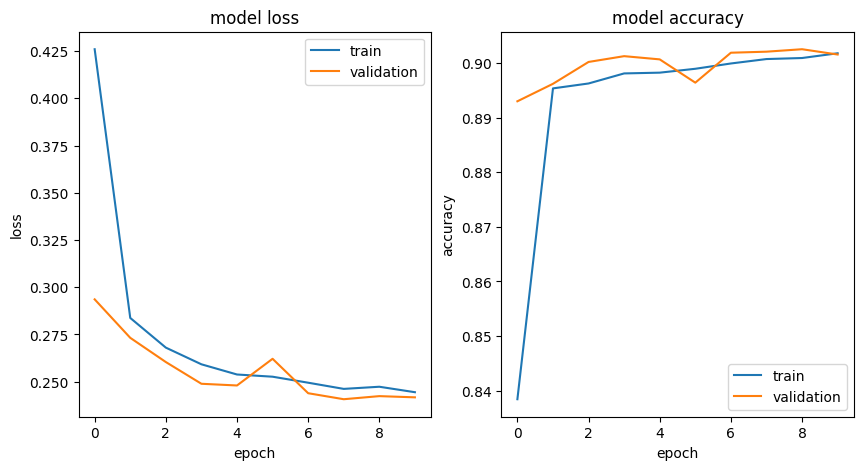

min train loss 0.244 at ep. 9
min valid loss 0.241 at ep. 7
best valid accurracy   0.90 at ep. 8


In [13]:
hlp.plots.plotLearningCurvesSkorch(net.history)

Maybe not yet the optimal accuracy.
Skorch allows to continue the traing: partial_fit instaed of fit.

In [14]:
net.partial_fit(ds_train, ds_train.tensors[1])

     11      0.9014     0.9572        0.2449       0.9028        0.2415  2.7542
     12      0.9015     0.9591        0.2444       0.9054        0.2354  2.0422
     13      0.9026     0.9593        0.2417       0.9055        0.2351  2.3481
     14      0.9032     0.9587        0.2410       0.9054        0.2369  2.0367
     15      0.9045     0.9584        0.2380       0.9050        0.2364  2.3258
     16      0.9042     0.9590        0.2398       0.9049        0.2366  2.6846
     17      0.9050     0.9602        0.2380       0.9041        0.2371  2.0997
     18      0.9037     0.9598        0.2388       0.9024        0.2431  2.3410
     19      0.9052     0.9605        0.2359       0.9070        0.2346  2.0415
     20      0.9058     0.9609        0.2348       0.9072        0.2305  2.0867


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

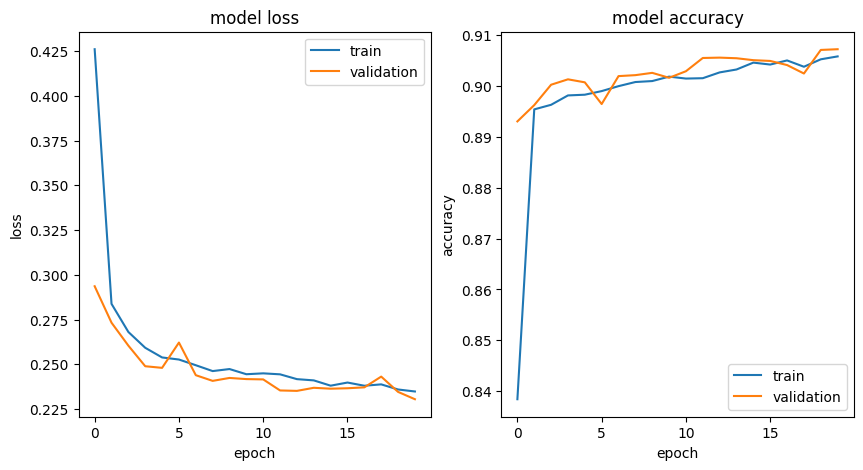

min train loss 0.235 at ep. 19
min valid loss 0.230 at ep. 19
best valid accurracy   0.91 at ep. 19


In [15]:
hlp.plots.plotLearningCurvesSkorch(net.history)

In [16]:
net.partial_fit(ds_train, ds_train.tensors[1])

     21      0.9063     0.9609        0.2342       0.9079        0.2301  2.8175
     22      0.9071     0.9624        0.2317       0.9101        0.2251  2.0852
     23      0.9071     0.9632        0.2311       0.9112        0.2232  2.3410
     24      0.9076     0.9634        0.2288       0.9096        0.2248  2.0588
     25      0.9090     0.9592        0.2286       0.9056        0.2366  2.6066
     26      0.9094     0.9642        0.2269       0.9114        0.2220  2.6496
     27      0.9091     0.9646        0.2274       0.9129        0.2185  2.0534
     28      0.9102     0.9647        0.2246       0.9122        0.2188  2.0518
     29      0.9104     0.9657        0.2239       0.9141        0.2148  2.0972
     30      0.9113     0.9647        0.2225       0.9133        0.2171  2.6910


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

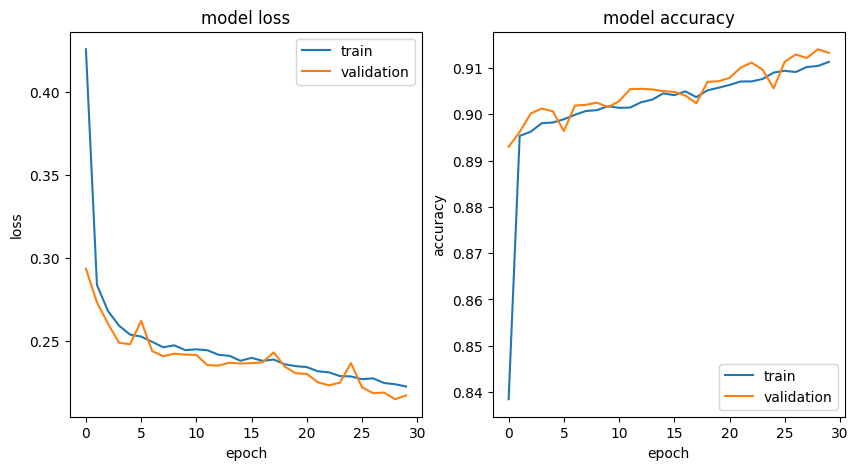

min train loss 0.222 at ep. 29
min valid loss 0.215 at ep. 28
best valid accurracy   0.91 at ep. 28


In [17]:
hlp.plots.plotLearningCurvesSkorch(net.history)

Still improvement, we need more then 10 additional epochs.

In [18]:
net.max_epochs=30
net.partial_fit(ds_train, ds_train.tensors[1])

     31      0.9127     0.9662        0.2199       0.9152        0.2134  2.5449
     32      0.9137     0.9665        0.2186       0.9144        0.2165  2.0640
     33      0.9133     0.9671        0.2176       0.9162        0.2101  2.3380
     34      0.9144     0.9669        0.2163       0.9159        0.2111  2.1190
     35      0.9150     0.9666        0.2157       0.9155        0.2116  2.7287
     36      0.9150     0.9665        0.2140       0.9163        0.2125  2.3000
     37      0.9159     0.9685        0.2121       0.9164        0.2104  2.0767
     38      0.9165     0.9682        0.2119       0.9190        0.2071  2.0795
     39      0.9176     0.9700        0.2083       0.9206        0.2009  2.3425
     40      0.9173     0.9691        0.2091       0.9199        0.2025  2.9988
     41      0.9177     0.9689        0.2073       0.9189        0.2053  2.0833
     42      0.9184     0.9703        0.2053       0.9212        0.2018  2.3178
     43      0.9195     0.9715        0.

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=myModel(
    (inLay): Linear(in_features=200, out_features=200, bias=True)
    (linears): ModuleList(
      (0-4): 5 x Linear(in_features=200, out_features=200, bias=True)
    )
    (bnorms): ModuleList(
      (0-4): 5 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (outLay): Linear(in_features=200, out_features=1, bias=True)
  ),
)

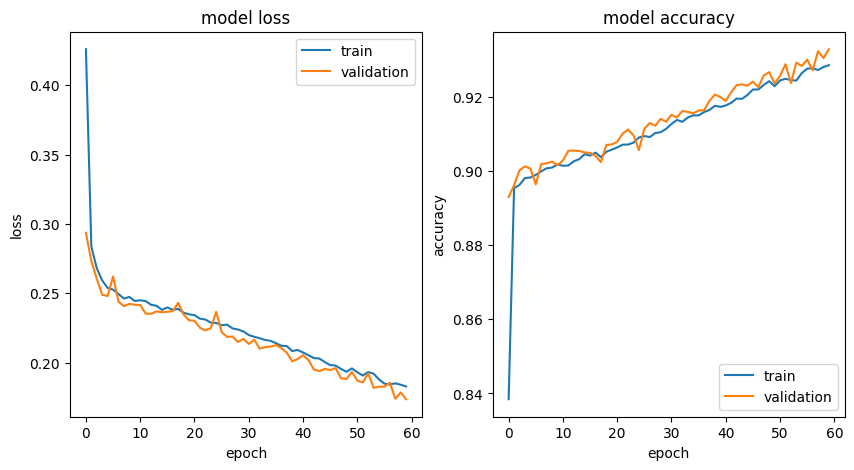

min train loss 0.183 at ep. 59
min valid loss 0.174 at ep. 59
best valid accurracy   0.93 at ep. 59


In [19]:
hlp.plots.plotLearningCurvesSkorch(net.history)

Scikit-learn provides a  grid search for the best hyperparameter (GridSearchCV). Skorch works smootly with this. Different models hyperparameters are possible *module__mid_size* means myModel parameter mid_size.

In [20]:
from sklearn.model_selection import GridSearchCV
net.max_epochs=8
# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=1)
params = {
    'lr': [0.001, 0.002, 0.005],
    'module__mid_size': [50,100,200,400,600],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(ds_train.tensors[0], ds_train.tensors[1])
print(gs.best_score_, gs.best_params_)

  epoch    accuracy    train_loss     dur
-------  ----------  ------------  ------
      1      0.7629        0.5083  0.9227
      2      0.8859        0.3342  0.9243
      3      0.8951        0.2910  0.9163
      4      0.8949        0.2834  1.1939
      5      0.8985        0.2731  0.9444
      6      0.8988        0.2682  0.9007
      7      0.8978        0.2638  0.9372
      8      0.8986        0.2589  1.2394
  epoch    accuracy    train_loss     dur
-------  ----------  ------------  ------
      1      0.7695        0.5161  1.3227
      2      0.8746        0.3678  0.9246
      3      0.8892        0.3100  0.9205
      4      0.8915        0.2913  0.9190
      5      0.8975        0.2789  0.9000
      6      0.8977        0.2703  0.9068
      7      0.8986        0.2640  0.9256
      8      0.9004        0.2561  1.1689
  epoch    accuracy    train_loss     dur
-------  ----------  ------------  ------
      1      0.7602        0.5184  0.9089
      2      0.8668        0.3893 

In [21]:
model=myModel(mid_size=50)

In [23]:
from skorch import NeuralNetClassifier
net = NeuralNetClassifier(
    model,
    criterion=nn.BCELoss,
    optimizer=torch.optim.Adam,
    lr=0.001,
    batch_size=500,
    max_epochs=200,
    callbacks=[acc,auc],
    train_split=predefined_split(ds_train),
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    #callbacks=[LivePlot],
    device=device
)

In [ ]:
net.fit(ds_train, ds_train.tensors[1])

  epoch    accuracy    roc_auc    train_loss    valid_acc    valid_loss     dur
-------  ----------  ---------  ------------  -----------  ------------  ------
      1      0.8311     0.9267        0.4524       0.8803        0.3657  2.3926
      2      0.8909     0.9375        0.3130       0.8951        0.2915  2.1115
      3      0.8956     0.9444        0.2782       0.9000        0.2641  2.4506
      4      0.8975     0.9502        0.2645       0.8989        0.2553  2.6096
      5      0.8981     0.9536        0.2574       0.9000        0.2511  2.0575
      6      0.8996     0.9548        0.2520       0.9003        0.2502  2.6521
      7      0.8994     0.9545        0.2519       0.9007        0.2476  2.2985
      8      0.9003     0.9550        0.2504       0.8994        0.2500  2.8758
      9      0.8999     0.9548        0.2504       0.9014        0.2486  2.0788
     10      0.9008     0.9538        0.2490       0.9011        0.2486  2.3132
     11      0.9010     0.9540        0.

In [ ]:
hlp.plots.plotLearningCurvesSkorch(net.history)